<a href="https://colab.research.google.com/github/Olubayosam/Authentication-Secrets/blob/master/empty_room.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the important packages, put sionna import in a try catch error, to check if google colab already has it in this instance or install it via pip


In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Transmitter, PlanarArray, Receiver, PathSolver, Camera, RadioMapSolver

Load up the empty room made of concrete, the material specification is important as it affects the way rays are propagated.

In [3]:
# the room dimension is 10 x 10 x 5
xml_path = "/content/drive/MyDrive/Colab Notebooks/empty_room/ble_room_scene.xml"
scene = load_scene(xml_path)
scene.max_depth = 2  # Allow up to 1 reflection

specify tx and rx positions at each end of the room, set the orientation such that they point at each other, and add them to the scene object. put it in a try catch block to prevent value error when run multiple times.

In [4]:
# Add transmitter and receiver
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")



tx = Transmitter(name="tx1", position=[-5, 0, 3], display_radius=0.25)
rx = Receiver(name="rx1", position=[5, 0, 3], display_radius=0.25)
tx.look_at(rx.position)
rx.look_at(tx.position)

#scene.remove("tx1")
#scene.remove("rx1")

try:
  scene.add(tx)
  scene.add(rx)
  print("Tx and Rx added")
except ValueError as e:
      print("Tx and Rx already added")




Tx and Rx added


Define the camera parameters and orientation, place the camera high up enough, looking almost vertically downward at the room so as to cover the entire room.

In [ ]:
# Place camera at a height of 30 m, looking toward center of room
camera = Camera(position=[1, 2, 30], look_at=[0, 0, 0])

Visualize the set up, set the visualization angle so that it shows inside the enclosed room.

Red is the Transmitter,
Green is the receiver.

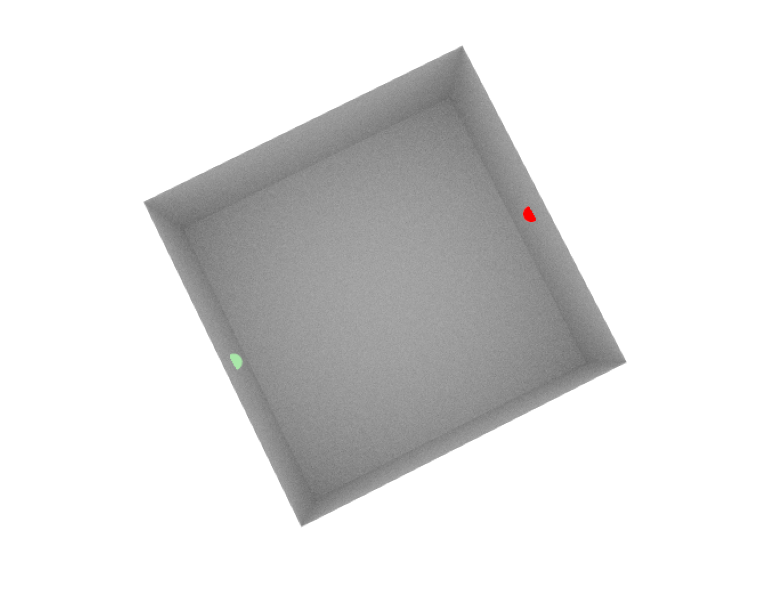

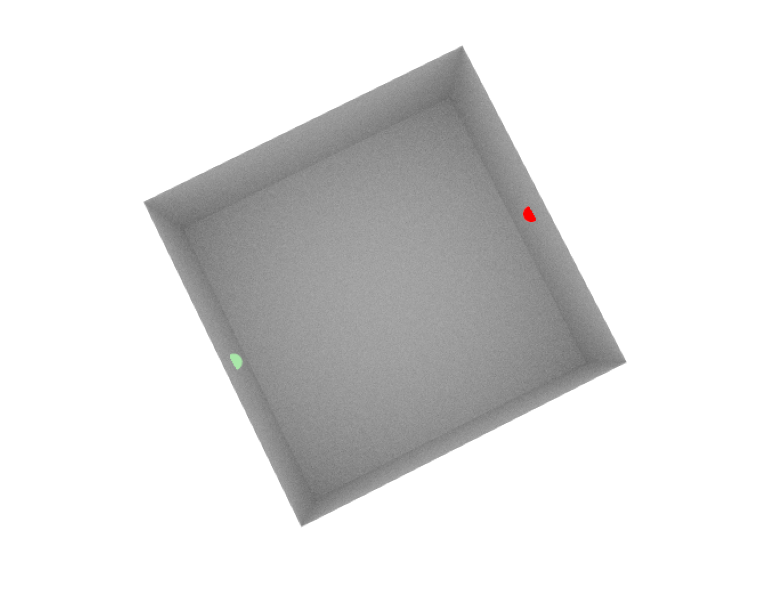

In [7]:
# Visualize the setup
scene.render(camera=camera)


Compute the path of the rays

In [8]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=2,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

Visualize the rays

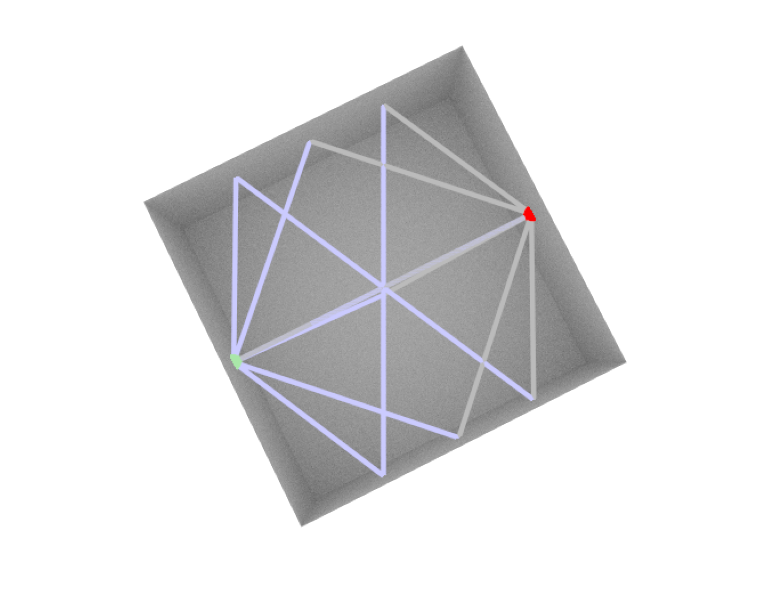

In [9]:
# Visualize paths
try:
    scene.render(paths=paths, camera=camera)
except TypeError as e:
    # Check if the error message matches the expected NoneType error
    if "cannot unpack non-iterable NoneType object" in str(e):
        print("No paths found to render.")
    else:
        # If it's a different TypeError, re-raise it
        raise e

Radio map

In [12]:
# Generate and plot radiomap
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=2,
               cell_size=[1,1],
               samples_per_tx=10**6)

Plot the radio map,

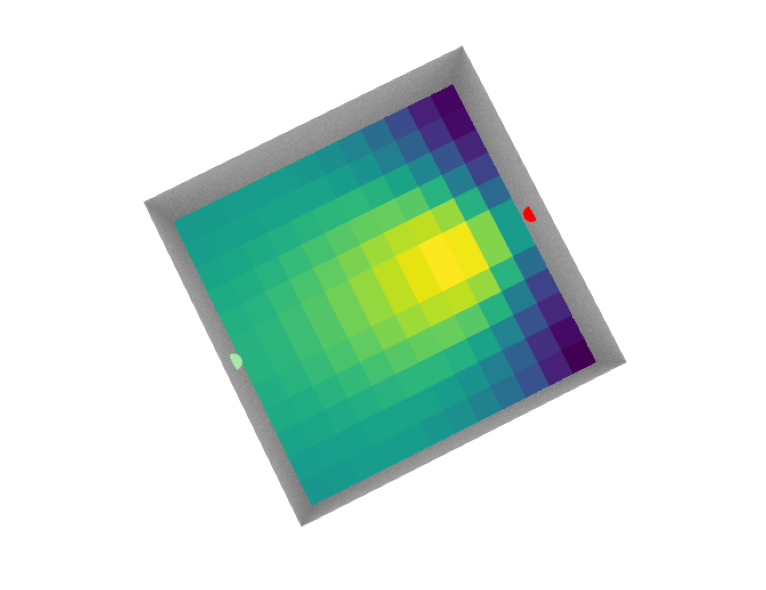

In [15]:
scene.render(camera=camera, radio_map=rm);

# Channel impulse response
Hopefully, we can get meaning full data from the CIR.

**a** = complex gain coefficients of each multipath component (amplitude + phase)


**tau** = delay of each path (i.e., when each echo arrives at the receiver)



In [23]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

print("Delays (ns) TOA Normalized:", tau[0, 0, 0, 0, :] * 1e9)
print("Amplitudes:", np.abs(a[0, 0, 0, 0, :, 0]))


Shape of a:  (1, 2, 1, 1, 7, 1)
Shape of tau:  (1, 2, 1, 1, 7)
Delays (ns) TOA Normalized: [ 0.        13.816678  13.816678  41.230793  41.230793  66.71282
  5.5435157]
Amplitudes: [1.4827687e-03 2.5646624e-04 2.5646624e-04 3.3758526e-05 3.3758541e-05
 8.8140223e-05 8.7182547e-05]


Plot the absolute value of **a** i.e Amplitude of received signal, against the time of arrival **tau** scaled to nano seconds.

[ 0.       13.816678 13.816678 41.230793 41.230793 66.71282   5.543516]
Max amplitude (LOS):  0.0014827687


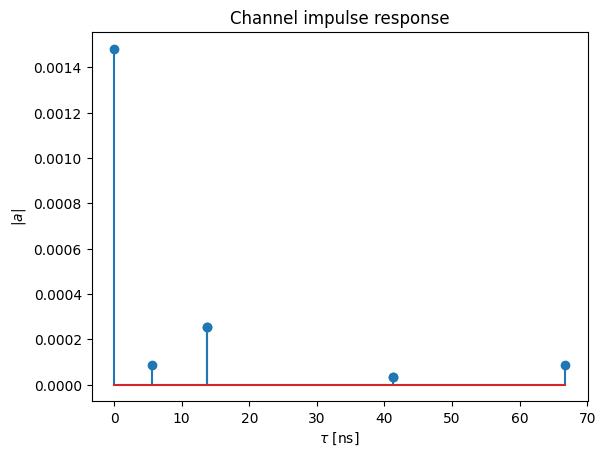

In [22]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [25]:
rssi_total = np.sum(a_abs**2) # total received signal strength
rssi_max_path = np.max(a_abs)**2 # recieved signal strength of the LOS

print("Total RSSI (linear):", rssi_total)
print("In dB:", 10*np.log10(rssi_total))
print("Max-path RSSI (LOS):", rssi_max_path)
print("Delays (ns) TOA Normalized:", t)
print("Min TOA (LoS):", np.min(t))


Total RSSI (linear): 2.3478015e-06
In dB: -56.29339
Max-path RSSI (LOS): 2.198603e-06
Delays (ns) TOA Normalized: [ 0.       13.816678 13.816678 41.230793 41.230793 66.71282   5.543516]
Min TOA (LoS): 0.0
